<a href="https://colab.research.google.com/github/sara-zinnat/question-rewrite/blob/main/NLP_Question_Rewrite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP Question Rewriter**

**Does denoising and data augmentation help for rewriting better questions? Fine tuning BART for question rewriting task**

Report on Developing a question rewrite model for the Disfl-QA benchmark dataset.

**Author:** Sara Binte Zinnat

**Email:** shazsara20@gmail.com

December 5, 2021

## **Instruction:**
1. To set runtime to GPU: Runtime->Change runtime type->Hardware accelerator->GPU
2. To get the baseline model result, evaluate the test_dataset without finetuning BART 
3. To do the experiment without augmentation, don't run the coding section under 'Data augmentation'
4. To get the result with augmented dataset, run the coding section under 'Data augmentation'

---

## **Mounting Goodle drive with Google Colab**

1. First download the dataset 'Disfl-QA' from https://github.com/google-research-datasets/Disfl-QA
2. Then upload the 'Disfl-QA' folder in Google Drive
3. Finally mount your drive using the following code

Here the path of 'Disfl-QA' folder is: /content/gdrive/MyDrive/Disfl-QA-main

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


---

## **Read JSON files**
* This section reads three json files namely, train/dev/test and 
* assigns them on six different lists: *train_src, train_tgt, val_src, val_tgt, test_src, test_tgt*.

In [ ]:
import json

dir = '/content/gdrive/MyDrive/Disfl-QA-main/'

with open(dir+'train.json', 'r') as f:
  train_data = json.load(f)

train_src = []
train_tgt = []

for d in train_data:
  train_src.append(train_data[d]["disfluent"]) 
  train_tgt.append(train_data[d]["original"])

#print(train_src[100])
#print(train_tgt[100])

with open(dir+'dev.json', 'r') as f:
  val_data = json.load(f)

val_src = []
val_tgt = []

for d in val_data:
  val_src.append(val_data[d]["disfluent"]) 
  val_tgt.append(val_data[d]["original"])

#print(val_src[100])
#print(val_tgt[100])

with open(dir+'test.json', 'r') as f:
  test_data = json.load(f)

test_src = []
test_tgt = []

for d in test_data:
  test_src.append(test_data[d]["disfluent"]) 
  test_tgt.append(test_data[d]["original"])

#print(test_src[100])
#print(test_tgt[100])

---

##**Selecting 'cuda' as device if available**

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


---

##**Data Preprocessing**

**Instaling Transformers:**

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 7.4 MB/s 
     |████████████████████████████████| 895 kB 52.9 MB/s 
     |████████████████████████████████| 3.3 MB 54.8 MB/s 
     |████████████████████████████████| 596 kB 64.1 MB/s 
     |████████████████████████████████| 61 kB 636 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


###**Data augmentation [Run this part when you want to use Data Augmentation]**

Here I have implemented two different approaches for the data preprocessing to compare the results. 

*   In first approach, I have used data augmentation where I have shuffeled the words in the disfluent questions (source) and kept the fluent questions (target) unchanged. I have done this for each sample. That is why my training dataset will be doubled in size. ***Run this part***.
*   In second approach, no data augmentation is used. Then you have to ignore this part. ***Don't run this part***.
* Finally, in both approaches, I have used BART's tokenizer namely 'BartTokenizer' where I have set the parameters as padding=True and return_tensors='pt'. As the disfluent (source) and fluent (target) questions' length are small in size, I have set padding=True to make the input and output size of uniform length.

In [ ]:
import random

def dataAugmentation(x, y):
  size = len(x)
  for i in range(size):
    wordlist = x[i].split()
    random.shuffle(wordlist)
    new_sentence = ' '.join(wordlist)
    x.append(new_sentence)
    y.append(y[i])


dataAugmentation(train_src, train_tgt)
dataAugmentation(val_src, val_tgt)

### **Tokenizing data by using BartTokenizer and preparing them as Tensor**

❗ We must install transformers for continuing next steps. 

[*Code for installing transformers is given at the beginning of Data Preprocessing section*]

In [ ]:
from transformers import BartTokenizer
import torch

class BartDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])
        return item
    def __len__(self):
        return len(self.labels['input_ids'])

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')

def tokenize_data(texts, labels):
  encodings = tokenizer(texts,  padding=True)
  decodings = tokenizer(labels, padding=True)
  dataset_tokenized = BartDataset(encodings, decodings)
  return dataset_tokenized

train_dataset = tokenize_data(train_src, train_tgt)
val_dataset = tokenize_data(val_src, val_tgt)
test_dataset = tokenize_data(test_src, test_tgt)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

##**Fine Tuning BART model**

*  At this point we are going to use a trainer to fine tune the BART model by setting the parameters of the trainer.


### **Training**


In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
import torch
import shutil

model_name = 'facebook/bart-large'

model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

training_args = TrainingArguments(
  output_dir='/content/gdrive/MyDrive/Disfl-QA-main/results',
  evaluation_strategy='steps',
  eval_steps=100,
  warmup_steps=500,
  weight_decay=0.01,
  logging_dir='/content/gdrive/MyDrive/Disfl-QA-main/logs',
  logging_steps=10,
  
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,

  load_best_model_at_end=True,
)

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
  tokenizer=tokenizer
)

Downloading:   0%|          | 0.00/971M [00:00<?, ?B/s]

#### **Start Fine-tuning**

[skip this step if you want to get the baseline result]

In [ ]:
import shutil
import os

trainer.train()

dir = '/content/gdrive/MyDrive/Disfl-QA-main/model'

if os.path.isdir(dir):
  shutil.rmtree(dir)

model.save_pretrained(dir)

***** Running training *****
  Num examples = 7182
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1347


Step,Training Loss,Validation Loss
100,5.066300,4.120363
200,2.238700,1.731243
300,0.174500,0.178013
400,0.149500,0.168917
500,0.137100,0.199508
600,0.136900,0.173199
700,0.103000,0.152560
800,0.118100,0.143438
900,0.090200,0.142074
1000,0.059500,0.152700


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to /content/gdrive/MyDrive/Disfl-QA-main/results/checkpoint-500
Configuration saved in /content/gdrive/MyDrive/Disfl-QA-main/results/checkpoint-500/config.json
Model weights saved in /content/gdrive/MyDrive/Disfl-QA-main/results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Disfl-QA-main/results/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Disfl-QA-main/results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1000
  Batch

## **Model Evaluation**

In [ ]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 3643
  Batch size = 64


{'epoch': 3.0,
 'eval_loss': 0.1472976952791214,
 'eval_runtime': 22.3843,
 'eval_samples_per_second': 162.748,
 'eval_steps_per_second': 2.546}

### **Calculating ROUGE score**

#### **Install ROUGE**

In [ ]:
!pip install rouge

#### **Get ROUGE score**

❗ Install rouge before using it. Execute previous coding section.

In [ ]:
from rouge import Rouge 
import tqdm.notebook as tq

def makePrediction (hypothesis):
  input_ids = tokenizer.encode(hypothesis, padding=True, return_tensors='pt').to(device)
  output = model.generate(input_ids, max_length=15, min_length=12)
  prediction = tokenizer.decode(output[0], skip_special_tokens=True)
  
  return prediction


size = len(test_src)

modelGenerated = []

for i in  tq.tqdm(range(size)):
  modelGenerated.append (makePrediction(test_src[i]))

rouge = Rouge()

scores = rouge.get_scores(modelGenerated, test_tgt)

avg_score = {'r1r':0, 'r1p':0, 'r1f':0, 'r2r':0, 'r2p':0, 'r2f':0, 'rlr':0, 'rlp':0, 'rlf':0}
size = len(scores)

for i in tq.tqdm(range(size)):
  avg_score['r1r'] = avg_score['r1r'] + (scores[i]['rouge-1']['r'])
  avg_score['r1p'] = avg_score['r1p'] + (scores[i]['rouge-1']['p'])
  avg_score['r1f'] = avg_score['r1f'] + (scores[i]['rouge-1']['f'])
  avg_score['r2r'] = avg_score['r2r'] + (scores[i]['rouge-2']['r'])
  avg_score['r2p'] = avg_score['r2p'] + (scores[i]['rouge-2']['p'])
  avg_score['r2f'] = avg_score['r2f'] + (scores[i]['rouge-2']['f'])
  avg_score['rlr'] = avg_score['rlr'] + (scores[i]['rouge-l']['r'])
  avg_score['rlp'] = avg_score['rlp'] + (scores[i]['rouge-l']['p'])
  avg_score['rlf'] = avg_score['rlf'] + (scores[i]['rouge-l']['f'])

print('Rouge-1 (R): ' + str(avg_score['r1r']/size*100))
print('Rouge-1 (P): ' + str(avg_score['r1p']/size*100))
print('Rouge-1 (F1-Score): ' + str(avg_score['r1f']/size*100))
print('Rouge-2 (R): ' + str(avg_score['r2r']/size*100))
print('Rouge-2 (P): ' + str(avg_score['r2p']/size*100))
print('Rouge-2 (F1-Score): ' + str(avg_score['r2f']/size*100))
print('Rouge-L (R): ' + str(avg_score['rlr']/size*100))
print('Rouge-L (P): ' + str(avg_score['rlp']/size*100))
print('Rouge-L (F1-Score): ' + str(avg_score['rlf']/size*100))


  0%|          | 0/3643 [00:00<?, ?it/s]

  0%|          | 0/3643 [00:00<?, ?it/s]

Rouge-1 (R): 85.44511251720463
Rouge-1 (P): 92.36279108088075
Rouge-1 (F1-Score): 88.12352222644967
Rouge-2 (R): 80.91989932285523
Rouge-2 (P): 88.16605924346821
Rouge-2 (F1-Score): 83.63207371500033
Rouge-L (R): 85.00795563691788
Rouge-L (P): 91.86347911094022
Rouge-L (F1-Score): 87.66438121170862


---
---

## **Additional Analysis for understanding the dataset:**

Training dataset
Total # of Document:  7182
Total # of Words in target:  70602
Total # of Document where at least one word in target did not match with source:  2951
Total # of Words of the targets which did not match with source:  4543
4.751461988304094

 Augmented dataset
Total # of Document:  14364
Total # of Words in target:  141204
Total # of Document where at least one word in target did not match with source:  5902
Total # of Words of the targets which did not match with source:  9086


"\nprint('\n Validation dataset')\nanalyse(val_data)\nprint ('\n Augmented dataset')\nprintdata(val_src, val_tgt)\n\nprint('\n Testing dataset')\nanalyse(test_data)\n"

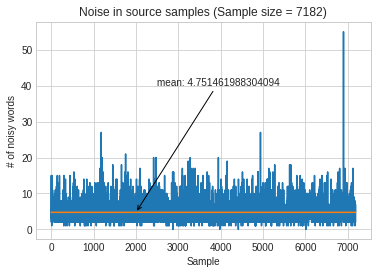

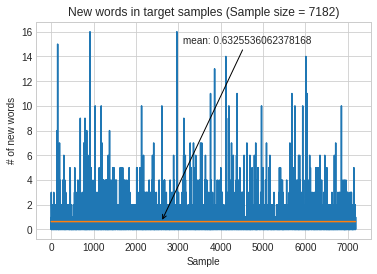

In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

def printdata (source, target):
  numDoc = 0
  numWrd = 0
  numDocNotFound = 0
  numWrdNotFound = 0
  size = len(source)
  
  for i in range(size):
    status = False
    src = source[i].split()
    tgt = target[i].split()
    for w in tgt:
      numWrd+=1
      if w not in src:
        numWrdNotFound+=1
        status = True
    if status is True:
      numDocNotFound+=1
    numDoc+=1
  print('Total # of Document: ', numDoc)
  print('Total # of Words in target: ', numWrd)
  print('Total # of Document where at least one word in target did not match with source: ', numDocNotFound)
  print('Total # of Words of the targets which did not match with source: ', numWrdNotFound)


def analyse(data):
  numDoc = 0
  numWrd = 0
  numDocNotFound = 0
  numWrdNotFound = 0

  new_words = []
  noise = []

  for d in data:
    status = False
    src = str(data[d]["disfluent"]).split()
    tgt = str(data[d]["original"]).split()
    new_w = 0
    noise_w = 0
    for w in tgt:
      numWrd+=1
      if w not in src:
        numWrdNotFound+=1
        new_w += 1
        status = True
    
    for w in src:
      if w not in tgt:
        noise_w += 1

    if status is True:
      numDocNotFound+=1
    numDoc+=1
    new_words.append(new_w)
    noise.append(noise_w)

  print('Total # of Document: ', numDoc)
  print('Total # of Words in target: ', numWrd)
  print('Total # of Document where at least one word in target did not match with source: ', numDocNotFound)
  print('Total # of Words of the targets which did not match with source: ', numWrdNotFound)

  plt.figure()
  plt.legend(['y1'])
  x = np.linspace(0, len(noise), len(noise))
  plt.plot(x,noise)
  plt.plot(x, np.mean(noise) * np.ones(len(noise)))
  plt.title("Noise in source samples (Sample size = "+str(len(noise))+")")
  plt.xlabel("Sample")
  plt.ylabel("# of noisy words")
  plt.annotate('mean: '+str(np.mean(noise)), xy=(2000, np.mean(noise)), xytext=(2500, 40), arrowprops=dict(arrowstyle="->"))
  plt.savefig('/content/gdrive/MyDrive/Disfl-QA-main/noisyWords.png')

  plt.figure()
  plt.legend(['y2'])
  x = np.linspace(0, len(new_words), len(new_words))
  plt.plot(x,new_words)
  plt.plot(x, np.mean(new_words) * np.ones(len(new_words)))
  plt.title("New words in target samples (Sample size = "+str(len(noise))+")")
  plt.xlabel("Sample")
  plt.ylabel("# of new words")
  plt.annotate('mean: '+str(np.mean(new_words)), xy=(2600, np.mean(new_words)), xytext=(3100, 15), arrowprops=dict(arrowstyle="->"))
  plt.savefig('/content/gdrive/MyDrive/Disfl-QA-main/newWords.png')

  print(np.mean(noise))
  

print('Training dataset')
analyse(train_data)
print ('\n Augmented dataset')
printdata(train_src, train_tgt)

'''
print('\n Validation dataset')
analyse(val_data)
print ('\n Augmented dataset')
printdata(val_src, val_tgt)

print('\n Testing dataset')
analyse(test_data)
'''